# A Traffic Sign Recognition Classifier Using Tensorflow

Jun Zhu

In this project, a convolutional neural network (CNN) was build to classify traffic signs. The [data](https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip) used in training and testing this model, which are provided by Udacity, come from the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). It is a pickled data set in which all the images have been resized to 32x32.

In [1]:
import pickle
import math
import random
import time
import os

import numpy as np
from scipy import ndimage, misc
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.contrib.layers import flatten

In [2]:
### Global parameters

USE_AUG_DATA = True  # Whether to use the augmented data

VALI_FRACTION = 0.2  # Fraction of validaton data in the train data

ACTIVATION_FUNC = 'relu'  # Activation function name
 
BY_CHANNEL = False  # Data normalization by each channel
BY_ALL = True  # Data normalization by all pixels

CALI_W_INIT = False  # Weight calibration

BATCH_NORM = False  # Batch normalization (not implemented yet)
EPSILON = 1e-6  # Small number used in normalizaton to avoid divided-by-zero

SAMPLE_TRAIN = None  # Use a small sample data for training (for speed)

EPOCHS = 40
BATCH_SIZE = 128
DISP_PER_EPOCH = 5   # No. of print out information per epoch

DROP_OUT = True
KEEP_PROB = 0.5

LEARNING_RATE = 5e-4

TRAIN_FLAG = 1  # 0 for no training, 1 for restart training, 2 for continue training

save_path = './save'
if not os.path.exists(save_path):
    os.makedirs(save_path)

SAVE_PATH = save_path + '/TSCNN_222SAME_2fc1024_bs' + str(BATCH_SIZE) + '_aug_2Dpt_LR' \
            + str(LEARNING_RATE) + '_' + ACTIVATION_FUNC

---
## 1. Load The Data

In [3]:
### Download the data
import urllib.request
import zipfile


zip_file='data/traffic-signs-data.zip'
training_file = './data/train.p'
testing_file = './data/test.p'
signal_names_file = './data/signnames.csv'

download_progress = 0
def report(nblocks, block_size, file_size):
    """"""
    global download_progress
    
    download_percentage = 100*float(nblocks*block_size/file_size);
    if download_percentage > download_progress:
        download_progress += 10;
        print("{:03d}% of {:.1f}M bytes recieved.".format(int(download_percentage), file_size/1024**2))

if not os.path.isfile(training_file) or not os.path.isfile(testing_file):
    urllib.request.urlretrieve(
        url='https://d17h27t6h515a5.cloudfront.net/topher/\
        2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip', 
        filename=zip_file, reporthook=report)
    
    print("{} downloaded!".format(zip_file))
    
    zip_ref = zipfile.ZipFile(zip_file, 'r')
    zip_ref.extractall("./data")
    zip_ref.close()
    
    os.remove(zip_file)

In [4]:
### Load the pickled data

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train_, y_train_ = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
print("X_train size: {:.1f} Mb".format(X_train_.nbytes/1024**2))
print("X_test size: {:.1f} Mb".format(X_test.nbytes/1024**2))

with open(signal_names_file, 'rb') as f:
    signal_names = np.genfromtxt(f, delimiter=',', skip_header=1, dtype='str')[:,1]

assert(len(X_train_) == len(y_train_))
assert(len(X_test) == len(y_test))

X_train size: 114.9 Mb
X_test size: 37.0 Mb


---

## 2. Exploratory Data Analysis

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. These coordinates assume the original image. The pickled data contains resized versions (32x32) of these images.

In [5]:
# Number of training examples
n_train = len(X_train_)

# Number of testing examples.
n_test = len(X_test)

# Shape of an traffic sign image?
image_shape = X_train_[0].shape

# Unique classes/labels in the dataset.
n_classes = len(np.unique(y_train_))
assert(n_classes == len(signal_names))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


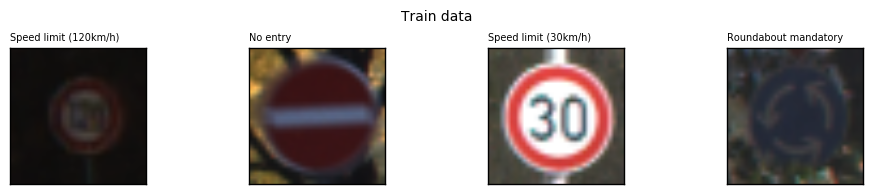

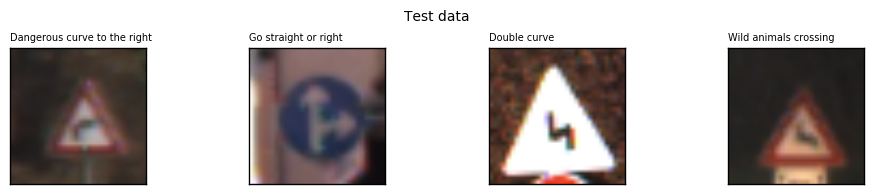

In [6]:
### Data visualization

def plot_signs(X_data, y_data=None, n_row=1, n_col=4, title=None, random_state=True, show_tick=False):
    """Visualize signs with labels.
    
    Parameters
    ----------
    X_data: array-like
        Image data.
    y_data: array-like
        Label data.
    n_row: int
        Number of rows.
    n_col: int
        Number of columns.
    title: string
        Super title of the plot.
    random_state: Boolean
        True for plotting random n_row x n_col data;
        False for plotting the first n_row x n_col data.
    """
    if random_state is True:
        index = np.array(random.sample(range(len(X_data)), n_row*n_col))
    else:
        index = np.array(range(n_row*n_col))

    fig, ax = plt.subplots(n_row, n_col, figsize=(2.5*n_col, 1.8*n_row))
    try:
        ax_ = ax.flatten()
    except AttributeError:
        ax_ = [ax]
    
    for i in range(len(ax_)):
        image = X_data[index[i]].squeeze()
        ax_[i].imshow(image)
        if show_tick is False:
            ax_[i].tick_params(axis='both', which='both', 
                               bottom='off', labelbottom='off', left='off', labelleft='off',
                               top='off', labeltop='off', right='off', labelright='off')
       
        if y_data is not None:
            ax_[i].set_title('{:}'.format(signal_names[y_data[index[i]]][:30]), fontsize=7, loc='left')
        
    if title is not None:    
        plt.suptitle(title, y=1.05)
    plt.subplots_adjust(wspace=0.2)
    plt.tight_layout()
    
        
plot_signs(X_train_, y_train_, n_row=1, title='Train data')
plot_signs(X_test, y_test, n_row=1, title='Test data')

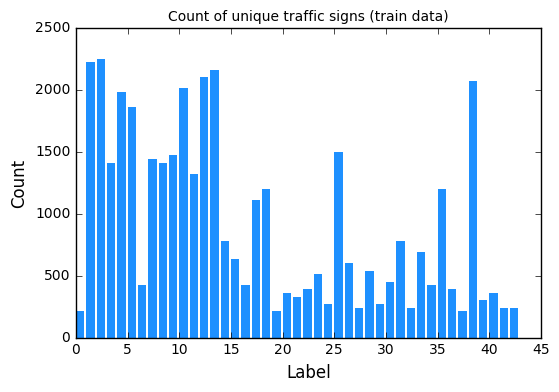

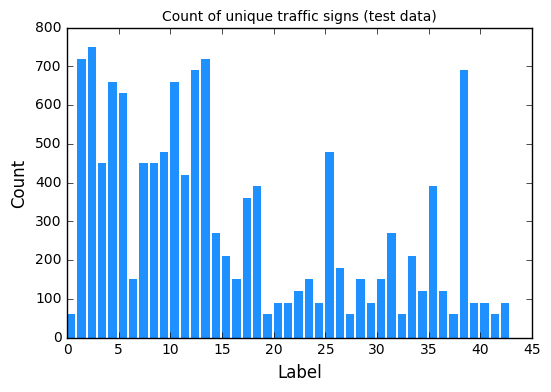

In [7]:
### Plot the count of each sign

def bar_plot(y_data, title=None):
    """"""
    u, counts = np.unique(y_data, return_counts=True)
    fig, ax = plt.subplots()

    ax.set_xlabel("Label", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    if title is None:
        ax.set_title("Count of unique traffic signs", fontsize=10)
    else:
        ax.set_title(title, fontsize=10)
    plt.bar(u, counts, edgecolor="none", color="dodgerblue")
    
bar_plot(y_train_, 'Count of unique traffic signs (train data)')
bar_plot(y_test, 'Count of unique traffic signs (test data)')

----
## 3. Data Augmentation

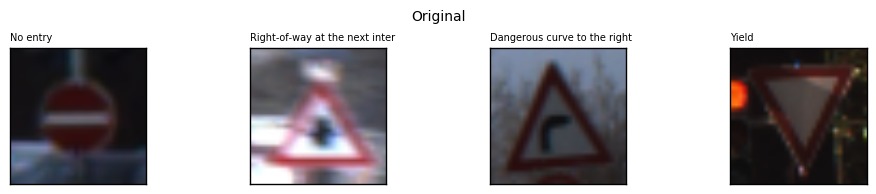

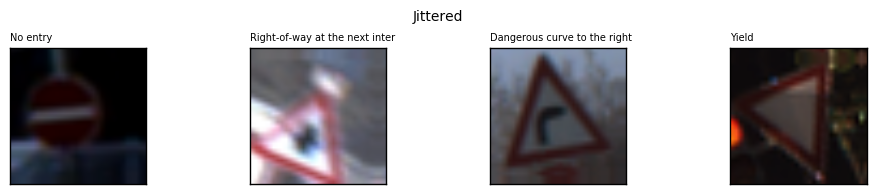

In [8]:
def jitter_image(img, angle=30.0, shift=4.0, gain=0.2, bias=20):
    """Apply random rotation, shift, brightness and constrast jitter to an image.

    img: array-like
        Input image.
    angle: int/float
        Angle is jittered between +/- angle.
    shift: int/float
        Shift is jittered between +/- shift (in pixel?).
    gain: int/float
        Contrast is jittered between 1 +/- gain.
    bias:
        Bias is jittered between +/- bias.
    
    Zoom is not included since the output image becomes too blurred.
    """
    image = img[:,:,:]

    # Rotation
    angle_ = (2*random.random() - 1.0)*angle
    image = ndimage.interpolation.rotate(image, angle_, reshape=False, mode='reflect')
    
    # Shift
    shift_ = [(2*random.random() - 1.0)*shift, (2*random.random() - 1.0)*shift, 0]
    image = ndimage.interpolation.shift(image, shift_, mode='reflect')
    
    # Brightness and contrast
    alpha = 1 + gain*(2*random.random() - 1.0)
    beta = bias*(2*random.random() - 1.0)
    image =  alpha*image + beta
    image[image > 255] = 255
    image[image < 0] = 0
    
    # Important to change the dtype to np.uint8!!!
    return image.astype(np.uint8)


### Test the jitter function

index = random.sample(range(len(X_train_)), 4)
plot_signs(np.array(X_train_[index]), np.array(y_train_[index]), random_state=False, title="Original")
X_train_jitter = []
y_train_jitter = []
for i in index:
    X_train_jitter.append(jitter_image(X_train_[i]))
    y_train_jitter.append(y_train_[i])
plot_signs(np.array(X_train_jitter), np.array(y_train_jitter), random_state=False, title="Jittered")

Loaded data from ./data/train_new.p
Number of training examples:  69448
Number of validation examples:  17362


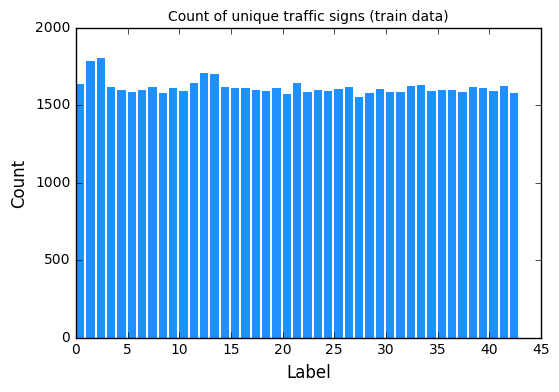

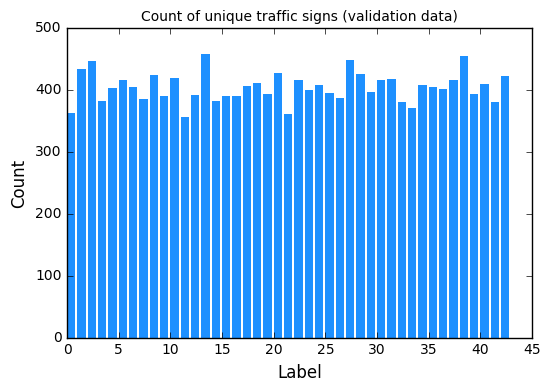

In [9]:
### Generate additional data to balance the sample sizes.

def augment_data(X_data, y_data, thresh):
    """Augment the data
    
    r
    The data with certain label will be augmented until its count reaches 'thresh'.
    """
    X_train_new = []
    y_train_new = []
    
    labels, counts = np.unique(y_train_, y_train_new, return_counts=True)
    addition = thresh - counts
    addition[addition < 0] = 0
    
    for i in range(len(labels)):
        pool_sample = X_data[y_data == labels[i]]
        length = len(pool_sample)
        for j in range(addition[i]):
            X_train_new.append(jitter_image(pool_sample[np.random.randint(length)]))
            y_train_new.append(labels[i])
            
        if addition[i] > 0:
            print("{} new data generated for label {}".format(addition[i], i))
    
    return np.array(X_train_new), np.array(y_train_new)
    

if USE_AUG_DATA is True:
    train_file_new = './data/train_new.p'

    try:
        with open(train_file_new, 'rb') as f:
            train_new = pickle.load(f)
            
        X_train_new, y_train_new = train_new['features'], train_new['labels']
        print("Loaded data from {}".format(train_file_new))
    except OSError:

        X_train_new, y_train_new = augment_data(X_train_, y_train_, 2500)
        
        train_new = {'features': X_train_new, 'labels': y_train_new}

        with open(train_file_new, 'wb') as f:
            pickle.dump(train_new, f)

        print("New data generated and save in {}".format(train_file_new))

    ### Merge the original and new data,
    ### then split the train data into training/validation sets
    X_train, X_vali, y_train, y_vali = \
        train_test_split(np.concatenate((X_train_, X_train_new)), 
                         np.concatenate((y_train_, y_train_new)), 
                         test_size=VALI_FRACTION, random_state=42)
        
    bar_plot(y_train, 'Count of unique traffic signs (train data)')
    bar_plot(y_vali, 'Count of unique traffic signs (validation data)')
else:
    X_train, X_vali, y_train, y_vali = \
        train_test_split(X_train_, y_train_, test_size=VALI_FRACTION, random_state=42)

        
n_train = len(X_train)
n_validation = len(X_vali)

print("Number of training examples: ", n_train)
print("Number of validation examples: ", n_validation)

----

## 4. Data Preprocessing

Each image in the training data was normalized by the mean and standard deviaton of pixels in the whole training data, namely
```
data -= np.mean(data)
data /= np.std(data)
```
The mean and standard deviation of the training data were then used to normalize the validation and testing data. There are already a lot of papers and discussions on the internet about how the data should be preprocessed: [cs231n](http://cs231n.github.io/neural-networks-2/#batchnorm), [stackexchange](http://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c) and [Sergey Ioffe and Christian Szegedy](https://arxiv.org/pdf/1502.03167v3.pdf), etc. It is of importance to normalize the data because:
- We would like all the features to have a similar range so that the gradients do not go out of control.
- Zero-centering and normalizing the data are important for activation functions like tanh since it can avoid saturation. 
- For image data, the data can be normalized by each pixel, by each channel or by all the pixels. The performances with different normalization methods are similar.

It is worth noting that the same mean and standard deviation should be used for all data sets. Normalizing the validation or test data set by its own mean and standard deviation is a sort of information leakage. Moreover, in the situation when we are going to predict only one data point each time, normalizing one data point with its mean and standard deviation means turning all the features into zero. However, in some special case, using different means and standard deviations for different data sets might be more reasonable. Suppose we are going to predict whether a student could get the scholarship based on his/her test scores. If the training data set is from school A, while the testing data set is from school B which uses a different grading system from school B. In this case, it is more reasonable to normlize the test scores of students in school B by its own mean and standard deviation.

Preprocessing done!


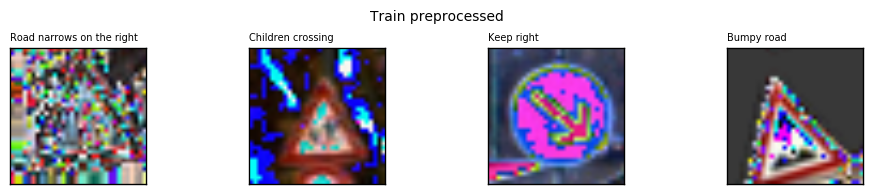

In [10]:
X_train_avg = 0
X_train_var = 1

def preprocess(data, norm=True, avg=None, var=None, by_channel=BY_CHANNEL, by_all=BY_ALL):
    """Preprocess (center/normalization) the data.

    By default the preprocess is apply to each pixel.

    Parameters
    ----------
    data: array-like
        Input data.
    norm: Boolean
        True for applying the normalization after mean subtraction.
    avg: int/float/tuple
        Specified mean used for mean subtraction.
    var: int/float/tuple
        Specified variance used for normalization.
    by_channel: Boolean
        True for mean subtraction by each channel;
    by_all: Boolean
        True for mean subtraction by all channels (data).

    Returns
    -------
    data_new: array-like
        Data after preprocessing.
    avg: float/tuple
        Data mean.
    var: float/tuple
        Data variation. 
    """
    epsilon = 1e-6  # Small number for numerical stability.
    
    if by_channel is True:
        if avg is None:
            avg = np.mean(data, axis=tuple(range(len(data.shape)-1)))
        if var is None:
            var = np.var(data, axis=tuple(range(len(data.shape)-1)))
    elif by_all is True:
        if avg is None:
            avg = np.mean(data)
        if var is None:
            var = np.var(data)
    else:
        if avg is None:
            avg = np.mean(data, axis=0)
        if var is None:
            var = np.var(data, axis=0)    
        
    if norm is True:
        data_new = (data - avg)/(np.sqrt(var + epsilon))
    else:
        var = 1.0
        data_new = (data - avg)/(1 + epsilon)
        
    return data_new, avg, var


X_train, X_train_avg, X_train_var = preprocess(X_train, norm=True)
X_vali, _, _ = preprocess(X_vali, avg=X_train_avg, var=X_train_var)
X_test, _, _ = preprocess(X_test, avg=X_train_avg, var=X_train_var )
print("Preprocessing done!")

plot_signs(X_train, y_train, title='Train preprocessed')

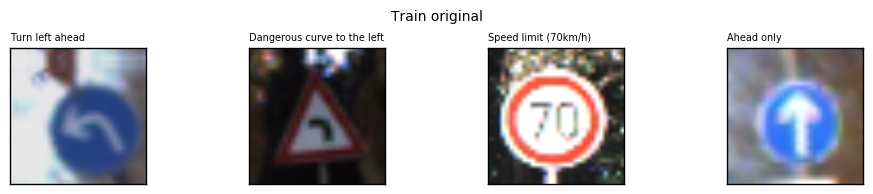

In [11]:
### Restore the image from preprocess. Only for visualization afterwards.

def restore(data, avg, var):
    """Retore a single image from mean subtraction.
    
    Paramters
    ---------
    data: array-like
        Input data set.
    avg: float/tuple
        Mean of the original data set.
    var: float/tuple
        Variance of the orginal data set.
        
    Return:
        Original data set.
    """
    return (data*np.sqrt(var + EPSILON) + avg).astype(np.uint8)


plot_signs(restore(X_train, X_train_avg, X_train_var), y_train, title='Train original')

----

## 5. Build the Convolutional Neural Network

In [12]:
### Define the convolutional neural network model.
IS_TRAINING = True

def layer_shape(x):
    """Get the shape of a layer"""
    shape = x.get_shape().as_list()[1:]
    
    text = str(shape[0])
    if len(shape) > 1:
        for i in shape[1:]:
            text += ' x {}'.format(str(i))
    
    return text


def activate(x):
    """Apply an activation function"""
    if ACTIVATION_FUNC.lower() == 'tanh':
        x_out = tf.nn.tanh(x)
    elif ACTIVATION_FUNC.lower() == 'relu':
        x_out = tf.nn.relu(x)
    else:
        raise ValueError("Unknow activation function!")
        
    print(ACTIVATION_FUNC.upper())

    return x_out


def batch_normalize(x, is_training=IS_TRAINING, epsilon=EPSILON):
    """Not implemented"""
    if is_training is True:
        batch_mean, batch_var = tf.nn.moments(x, [0])
    else:
        batch_mean, batch_var = X_train_avg, X_train_var  # Ugly
    
    return x
    # return tf.nn.batch_normalization(x, batch_mean, batch_var, epsilon)
        
        
def conv2d(x, W, b, strides, padding, bn=BATCH_NORM, epsilon=EPSILON):
    """Apply a 2D convolutional layer"""
    x_out = tf.nn.conv2d(x,  W, strides=strides, padding=padding)
    if bn is True:
        # Bias can be ignored for Batch normalization.
        print("Batch normalization")
        x_out = batch_normalize(x_out)
    else:
        x_out = tf.nn.bias_add(x_out, b)
    
    print("Conv2d -> {}, STDDEV of initial W: {:.2f}".
          format(layer_shape(x_out), weight_std))

    return activate(x_out)


def pooling(x, ksize, strides, padding, style='max'):
    """Apply a pooling layer"""
    if style.lower() == 'max':
        x_out = tf.nn.max_pool(x, ksize=ksize, strides=strides, padding=padding)
    else:
        raise ValueError('Unknown pooling style!')
    
    print("Pooling -> {}".format(layer_shape(x_out)))
    
    return x_out


def fully_connected(x, W, b, bn=BATCH_NORM):
    """Apply a fully connected layer"""
    x_out = tf.matmul(x, W)
    
    if bn is True:
        # Bias can be ignored for Batch normalization.
        print("Batch normalization")
            
        x_out = batch_normalize(x_out)
    else:
        x_out = tf.nn.bias_add(x_out, b)
    
    print("Full-connecting -> {}, STDDEV of initial W: {:.2f}".
              format(layer_shape(x_out), weight_std))
    
    return activate(x_out)
    

def cali_sigma(n):
    """Calibrating the variance
    
    To keep the variance of w*X an invariant.
    
    Parameters
    ----------
    n: int
        Number of neurons
    cali: Boolean
        True for applying the variance calibrating.
    
    Returns
    -------
    Standard deviation of the weight initialization.
    """
    if ACTIVATION_FUNC.lower() == 'tanh':
        return np.sqrt(1.0/n)
    elif ACTIVATION_FUNC.lower() == 'relu':
        return np.sqrt(2.0/n)
    else:
        raise ValueError("Unknown activation function!")

In [13]:
### Construct the training architecture/graph.
###
### Any change in the graph could induce weird result when loading the previously saved graph.

fsize = (3, 3)  # filter size

x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], image_shape[2]))
y = tf.placeholder(tf.int32, (None))

keep_prob = tf.placeholder(tf.float32)  # for drop-out layer

# Construct model

conv_padding = 'SAME'
pool_padding = 'SAME'

conv_params = [
    {'depth': 16, 'conv_strides': [1, 1, 1, 1]},
    {'depth': 16, 'conv_strides': [1, 1, 1, 1], 'pool_ksize': [1, 2, 2, 1], 'pool_strides': [1, 2, 2, 1]},
    {'depth': 32, 'conv_strides': [1, 1, 1, 1]},
    {'depth': 32, 'conv_strides': [1, 1, 1, 1], 'pool_ksize': [1, 2, 2, 1], 'pool_strides': [1, 2, 2, 1]},
    {'depth': 64, 'conv_strides': [1, 1, 1, 1]},
    {'depth': 64, 'conv_strides': [1, 1, 1, 1], 'pool_ksize': [1, 2, 2, 1], 'pool_strides': [1, 2, 2, 1]},
]

fc_params = [
    {'depth': 1024, 'keep': keep_prob},
    {'depth': n_classes, 'keep': keep_prob}
]

   
i_conv2d = 0  # Count of the convolutional layers
i_pooling = 0  # Count of the pooling layers
conv = x
print("CNN structure\n" + '-'*30)
print("Input -> {}\n".format(layer_shape(conv)))
old_depth = conv.get_shape().as_list()[3]
for param in conv_params:
    i_conv2d += 1

    if CALI_W_INIT is True:
        weight_std = cali_sigma(fsize[0]*fsize[1]*old_depth)
    else:
        weight_std = 0.1
    
    new_depth = param['depth']

    weight = tf.Variable(tf.truncated_normal([fsize[0], fsize[1], old_depth, new_depth], 
                                             stddev=weight_std), name='W-CONV' + str(i_conv2d))
    bias = tf.Variable(tf.zeros(new_depth), name='b-CONV' + str(i_conv2d))
    conv = conv2d(conv,  weight, bias, strides=param['conv_strides'], padding=conv_padding)
        
    old_depth = new_depth

    if 'pool_ksize' in param.keys():
        i_pooling += 1
        conv = pooling(conv, param['pool_ksize'], param['pool_strides'], padding=pool_padding, style='max')

fc = flatten(conv)

### Fully connected layers
### ----------------------
print()
i_fc = 0
i_drop = 0
old_depth = fc.get_shape().as_list()[1]
for param in fc_params:
    if param['keep'] is not None:
        i_drop += 1       
        fc = tf.nn.dropout(fc, param['keep'])
        
        print('DROP-OUT')
    
    i_fc += 1
    
    if CALI_W_INIT is True:
        weight_std = cali_sigma(old_depth)
    else:
        weight_std = 0.1
        
    new_depth = param['depth']
    weight = tf.Variable(tf.truncated_normal([old_depth, new_depth], 
                                             stddev=weight_std), name='W-FC' + str(i_fc))
    bias = tf.Variable(tf.zeros(new_depth), name='b-FC' + str(i_fc))
    fc = fully_connected(fc, weight, bias)
        
    old_depth = new_depth
        
logits = fc

print('\nOutput' + "-> {}".format(layer_shape(logits)))
print()
print('Total conv2d layers: {}'.format(i_conv2d))
print('Total pooling layers: {}'.format(i_pooling))
print('Total fully-connected layers: {}'.format(i_fc))
print('Total drop-out layers: {}'.format(i_drop))

# Training
one_hot_y = tf.one_hot(y, n_classes)

# Loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=one_hot_y)  # softmax + cross_entropy
cost = tf.reduce_mean(cross_entropy)  # Equivalent to np.mean()

# Optimizer
optimizer = tf.train.AdamOptimizer(LEARNING_RATE, beta1=0.9).minimize(cost)

# Initialization
init = tf.global_variables_initializer()

# Save
saver = tf.train.Saver()

# Evaluation
prediction_probability = tf.nn.top_k(tf.nn.softmax(logits), 5)
prediction_y = tf.argmax(logits, 1)
correct_prediction = tf.equal(prediction_y, tf.argmax(one_hot_y, 1))
prediction_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

CNN structure
------------------------------
Input -> 32 x 32 x 3

Conv2d -> 32 x 32 x 16, STDDEV of initial W: 0.10
RELU
Conv2d -> 32 x 32 x 16, STDDEV of initial W: 0.10
RELU
Pooling -> 16 x 16 x 16
Conv2d -> 16 x 16 x 32, STDDEV of initial W: 0.10
RELU
Conv2d -> 16 x 16 x 32, STDDEV of initial W: 0.10
RELU
Pooling -> 8 x 8 x 32
Conv2d -> 8 x 8 x 64, STDDEV of initial W: 0.10
RELU
Conv2d -> 8 x 8 x 64, STDDEV of initial W: 0.10
RELU
Pooling -> 4 x 4 x 64

DROP-OUT
Full-connecting -> 1024, STDDEV of initial W: 0.10
RELU
DROP-OUT
Full-connecting -> 43, STDDEV of initial W: 0.10
RELU

Output-> 43

Total conv2d layers: 6
Total pooling layers: 3
Total fully-connected layers: 2
Total drop-out layers: 2


In [14]:
def batch_data(data, size):
    """Return a generator of the batched data.
    
    Parameters
    ----------
    data: array-like
        Data.
    size: int
        Batch size.
    """
    if not isinstance(size, int):
        raise TypeError
    if size < 0:
        raise ValueError("Non-posive batch size!")
    
    for start in range(0, len(data), size):
        end = start + size
        yield data[start:end]

In [15]:
def evaluate(X_data, y_data, batch_size):
    """Evaluation the accuracy of the classifier.
    
    Parameters
    ----------
    X_data: array-like
        Features.
    y_data: array-like
        Labels.
    batch_size: int
        Batch size.
        
    Returns
    -------
    pred: list
        
    acc: list
        
    prob_values: list
        
    prob_indices: list
        
    """
    prob_values = []
    prob_indices = []
    pred = []
    for batch_X, batch_y in zip(batch_data(X_data, batch_size), 
                                batch_data(y_data, batch_size)):
        batch_prob, batch_pred = sess.run([prediction_probability, prediction_y], 
                                          feed_dict={x: batch_X, y: batch_y, keep_prob: 1.0})
        prob_values.extend(batch_prob[0])
        prob_indices.extend(batch_prob[1])
        pred.extend(batch_pred)
    
    corr = [a == b for a, b in zip(pred, list(y_data))]
    acc = np.array(corr).sum()/len(corr)

    assert(abs(acc - np.mean(pred == y_data)) < 1e-10)

    return pred, acc, prob_values, prob_indices

### 3.3 Train the neutral network

In [16]:
def load_model(session, path):
    """Load a pre-trained model from files.
    
    session: tf.Session() instance
        Session that the saved variables will be loaded into.
    path: string
        Path of the saved files
    """
    try:
        loaded_saver = tf.train.import_meta_graph(SAVE_PATH + '.meta')
        load_path = loaded_saver.restore(session, SAVE_PATH)
        print("Model has been loaded from {}".format(SAVE_PATH))
    except OSError:
        print("Save point does not exist!")
        raise SystemExit(0)
        
    return

In [17]:
### Sample a fraction of training data (for testing)

if SAMPLE_TRAIN is not None:
    if isinstance(SAMPLE_TRAIN, (int, float)) and 0 < SAMPLE_TRAIN <= 1.0:
        sample_index = random.sample(range(len(X_train)), int(len(X_train)*SAMPLE_TRAIN))
    else:
        raise ValueError

    X_train = X_train[sample_index]
    y_train = y_train[sample_index]
    print("The length of the sampled data set is : {}".format(len(X_train)))

__Traing strategy__

- First, the size of the neural network was chosen to be able to train a model using g2.2xlarge at AWS in a reasonable time. The training will be stopped after 40 epochs. 

- The softmax function is used to calculate the cross entropy and loss function after the read-out layer. The loss function will be iteratively optimizied by using the Stochastic Gradient Descend (SGD) algorithm, where the gradient of the loss function of a mini-batch (size=128) of the whole training data set will be evaluated and used to update the parameters for the next iteration. Specifically, [**Adam algorithm**](https://www.tensorflow.org/versions/r0.11/api_docs/python/train/optimizers#AdamOptimizer), which adaptively adjusts the learning rate, is used. It was found that the [**batch size**](http://stats.stackexchange.com/questions/140811/how-large-should-the-batch-size-be-for-stochastic-gradient-descent) barely influence the result. 

- I introduced the [**drop-out**](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf) layers to regularize my neural network. The purpose of regularization is to avoid overfitting introduced by the sampling noise which exists in the training data set but not in the test data set. After several experiments, I found out that having one drop-out layer before each of the first two fully-connected layers are necessary. The results with the drop-out layers improved greatly. It is must be pointed out that one must __turn off the drop-out layer during the evaluation of the validation data set__.

- The hyperparameters which have beeing tuned are learning rate (1e-2, 1e-3, 5e-4, 2e-4, 1e-4), keep probability (0.3, 0.5, 0.7) in the drop-out layers and the first moment decay rate $\beta_1$ (0.9, 0.8, 0.7) in the Adam optimizer. Finally, I came out with the following hyperparameters: learning rate - 5e-4, keep probability - 0.5 and $\beta_1$ - 0.9.

__Others__

- The results using different normalization methods (by each pixel, by each channel and by all the pixels) were compared. It was found that normalization by all the pixels has the best performance.

- Weight initialization is very important in training a neural network. For the activation function like sigmoid/tanh, there are vanishing and exploding gradient problems. If the weights are too small, then the signal shrinks as it propogates forward and the nonlinearty of the activation function gradually vanishes. If the weights are too large, then the signal grows as it propogates forward and the activation function gradually saturates. Therefore, the concept of variance calibration comes. The basic ideal of variance calibration is to normalize the variance of each neuron’s output to 1 by scaling the variance of its weight vector by 1/n, where n is the number of inputs features ([Glorot, et al.](http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf)):
\begin{equation*}
Var(\mathbf{s}) = Var(\sum_{i=1}^n w_ix_i) \approxeq nVar(\mathbf{w})Var(\mathbf{x}).
\end{equation*}
A similar analysis for the Relu activation function was carried out by [He, et al.](https://arxiv.org/abs/1502.01852). The conclusion is that the variance of the weight vector should be scaled by 2/n. However, in my study, the result became worse when the weight initialization was used. It has not been understood yet.

In [18]:
### Training

if TRAIN_FLAG not in [0, 1, 2]:
    raise ValueError()

disp_step = int(len(y_train)/BATCH_SIZE/(DISP_PER_EPOCH - 1))

i_iter = 0  # Count of batches
i_epoch = 0
# multi_cpu_config = tf.ConfigProto(intra_op_parallelism_threads=2)  # No effect!
with tf.Session() as sess:
    sess.run(init)
    
    if TRAIN_FLAG != 1:
        try:
            with open(SAVE_PATH + '.pkl', 'rb') as f:
                saved_training = pickle.load(f)
                i_epoch = saved_training['i_epoch']
                i_iter = saved_training['i_iter']
                cost_hist = saved_training['cost_hist']
                acc_hist = saved_training['acc_hist']
                vali_hist = saved_training['vali_hist']
                
                print("Result of save training:")
                print("EPOCH {:3d}, iter {:4d}, cost = {:8.4f}, epoch accuracy = {:8.4f}, "
                      "validation accuracy = {:8.4f}".
                      format(i_epoch, i_iter, cost_hist[-1], acc_hist[-1], vali_hist[-1]))
        except IOError:
            print("Not found: {}".format(SAVE_PATH + '.pkl'))

        load_model(sess, SAVE_PATH)
        if TRAIN_FLAG == 2:
            print("Continue with training...")
        else:
            print("Training skipped!")            
    else:
        cost_hist = []
        acc_hist = []
        vali_hist = []
        print("Training...")

    if TRAIN_FLAG != 0:       
        while i_epoch < EPOCHS:
            i_epoch += 1
            
            X_train, y_train = shuffle(X_train, y_train)
            
            cost_epoch = 0  # Cost over one EPOCH
            acc_epoch = 0  # Accuracy over one EPOCH      
            t_start = time.time()
            for batch_X, batch_y  in zip(batch_data(X_train, BATCH_SIZE), 
                                         batch_data(y_train, BATCH_SIZE)):
                i_iter += 1
                _, c, acc = sess.run([optimizer, cost, prediction_accuracy], 
                                feed_dict={x: batch_X, y: batch_y, keep_prob: KEEP_PROB})
                cost_epoch += c/len(batch_X)
                acc_epoch += acc*len(batch_X)
                
                if i_iter % disp_step == 0 or len(batch_X) < BATCH_SIZE:
                    dt = time.time() - t_start
                    print("EPOCH {:3d}/{:3d}, iter {:4d}, dt = {:4.1f} s, "
                          "batch cost = {:8.4f}, batch accuracy = {:8.4f}".
                          format(i_epoch, EPOCHS, i_iter, dt, c, acc))
                    t_start = time.time()
            
            acc_epoch /= len(X_train)
            
            _, acc_vali, _, _ = evaluate(X_vali, y_vali, BATCH_SIZE)

            cost_hist.append(cost_epoch)
            acc_hist.append(acc_epoch)
            vali_hist.append(acc_vali)
            
            print("epoch {:3d} cost = {:8.4f}, epoch accuracy = {:8.4f}, "
                  "validation accuracy = {:8.4f}".
                  format(i_epoch, cost_epoch, acc_epoch, acc_vali))
            
            with open(SAVE_PATH + '.pkl', 'wb') as f:
                pickle.dump({'i_epoch': i_epoch,
                             'i_iter': i_iter,
                             'cost_hist': cost_hist,
                             'acc_hist': acc_hist,
                             'vali_hist': vali_hist}, f)
            print("Result saved in file: {}".format(saver.save(sess, SAVE_PATH)))
            print()
                
        print("Training Done!\n")

Training...
EPOCH   1/ 40, iter  135, dt =  6.1 s, batch cost =   3.7323, batch accuracy =   0.0625
EPOCH   1/ 40, iter  270, dt =  5.5 s, batch cost =   3.3013, batch accuracy =   0.1406
EPOCH   1/ 40, iter  405, dt =  5.5 s, batch cost =   2.7611, batch accuracy =   0.2969
EPOCH   1/ 40, iter  540, dt =  5.5 s, batch cost =   2.2117, batch accuracy =   0.4297
EPOCH   1/ 40, iter  543, dt =  0.3 s, batch cost =   1.8767, batch accuracy =   0.5278
epoch   1 cost =  13.8613, epoch accuracy =   0.1617, validation accuracy =   0.5393
Result saved in file: ./save/TSCNN_222SAME_2fc1024_bs128_aug_2Dpt_LR0.0005_relu

EPOCH   2/ 40, iter  675, dt =  5.4 s, batch cost =   2.0258, batch accuracy =   0.4375
EPOCH   2/ 40, iter  810, dt =  5.5 s, batch cost =   1.3965, batch accuracy =   0.5703
EPOCH   2/ 40, iter  945, dt =  5.5 s, batch cost =   1.0231, batch accuracy =   0.7031
EPOCH   2/ 40, iter 1080, dt =  5.5 s, batch cost =   0.9294, batch accuracy =   0.7500
EPOCH   2/ 40, iter 1086, dt =

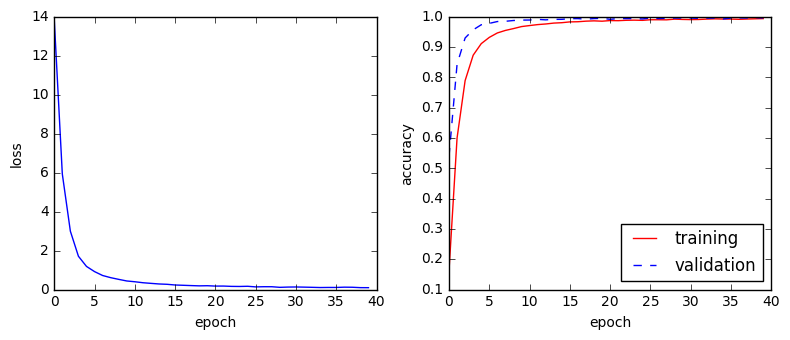

In [19]:
### Visualize the evolution of cost and accuracies

fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))

epochs = range(i_epoch)

ax[0].plot(epochs, cost_hist)
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')

ax[1].plot(epochs, acc_hist, 'r-', label='training')
ax[1].plot(epochs, vali_hist, 'b--', label='validation')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend(loc=4)

plt.tight_layout()
plt.show()

In [20]:
### Testing

print('Testing...')

with tf.Session() as sess:
    sess.run(init)
    
    load_model(sess, SAVE_PATH)
    
    test_pred, test_acc, test_prob_values, test_prob_indices = evaluate(X_test, y_test, BATCH_SIZE)

    print("Test Accuracy = {:.4f}".format(test_acc))
    
print('Testing done!')

Testing...
Model has been loaded from ./save/TSCNN_222SAME_2fc1024_bs128_aug_2Dpt_LR0.0005_relu
Test Accuracy = 0.9758
Testing done!


### 3.4 Visualize the prediction for the test data set

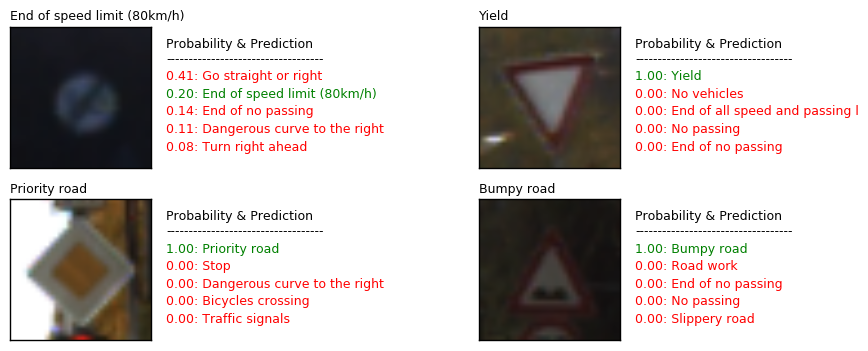

In [21]:
def plot_prediction(X_data, y_data=None, pred=None, prob_values=None, prob_indices=None, 
                    n_row=2, n_col=2, false_only=False, show_tick=False):
    """Visualize the predictions and probabilities
    
    Parameters
    ----------
    X_data:
    y_data:
    pred:
    prob_values:
    prob_indices:
    false_only:
    
    """
    font_size = 9
    
    assert(len(X_data) == len(pred) == len(prob_values) == len(prob_indices))
    if y_data is not None:
        assert(len(y_data) == len(X_data))
    
    if y_data is not None and false_only is True:
        corr = (y_data != pred)
        false_index = np.array(range(len(corr)))[corr]
        index = np.random.choice(false_index, n_row*n_col)
    else:
        index = random.sample(range(len(X_data)), n_row*n_col)
    
    fig, ax = plt.subplots(n_row, n_col, figsize=(6*n_col, 1.8*n_row))
    try:
        ax = ax.flatten()
    except AttributeError:
        ax = [ax]

    assert(len(index) == len(ax))
    for i, ax_now in zip(index, ax):
        prob_value = np.array(prob_values)[i]
        prob_index = np.array(prob_indices)[i]

        image = X_data[i].squeeze()
        ax_now.imshow(image)
        ax_now.tick_params(labelsize=7)

        if y_data is not None:
            true_label = y_data[i]
            title_string = signal_names[true_label]
        else:
            title_string = '???'
        ax_now.set_title(title_string, fontsize=font_size, loc='left')

        x0 = 35
        y0 = 11
        text_string ='Probability & Prediction\n' + '-'*35 + "\n"
        ax_now.text(x0, y0, text_string, fontsize=font_size)
        for v, ii in zip(prob_value, prob_index):
            if y_data is None:
                text_color = 'black'
            else:
                if true_label == ii:
                    text_color = 'green'
                else:
                    text_color = 'red'
            text_string = "{:.2f}: {}\n".format(v, signal_names[ii][:30])
            y0 += 4
            ax_now.text(x0, y0, text_string, color=text_color, fontsize=font_size)
            if show_tick is False:
                ax_now.tick_params(axis='both', which='both', 
                                   bottom='off', labelbottom='off', left='off', labelleft='off',
                                   top='off', labeltop='off', right='off', labelright='off')
    
    plt.tight_layout()


plot_prediction(restore(X_test, X_train_avg, X_train_var), y_test, 
                test_pred, test_prob_values, test_prob_indices)

**Visualize the false predictions**

It is found that the images that the classifier failed to predict generally have very poor quality. However, it is interesting to notice that the classifier is poor at indentifying numbers, e.g. the speed limit signs. It can tell the speed limit signs from the other signs, but it has difficulty in classifying the numbers which are not so difficult for human eyes.

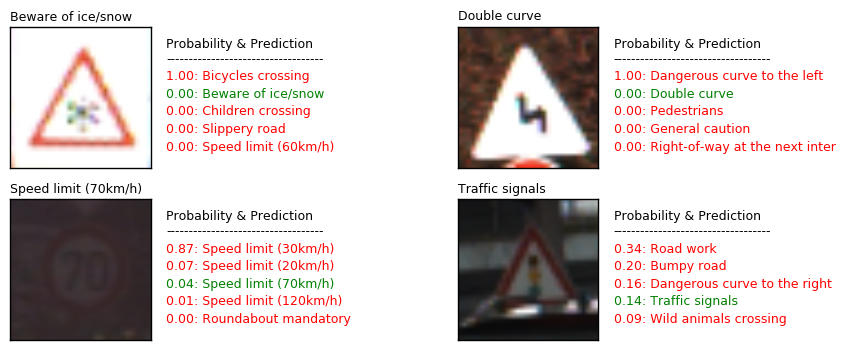

In [22]:
plot_prediction(restore(X_test, X_train_avg, X_train_var), y_test, 
                test_pred, test_prob_values, test_prob_indices, false_only=True)

---

## 4. Test a Model on New Images

The model is tested by using eight images taken on the road in Hamburg.

In [23]:
### Load the new images and resize them to 32x32x3

directory = './data'

imgs = []
for filename in os.listdir(directory):
    if filename.lower().endswith('jpg') is True:
        img = misc.imread(os.path.join(directory, filename))
        imgs.append(misc.imresize(img, (32, 32, 3)))

imgs = np.array(imgs)

Preprocessing done!
Testing new images...
Model has been loaded from ./save/TSCNN_222SAME_2fc1024_bs128_aug_2Dpt_LR0.0005_relu
Testing done!


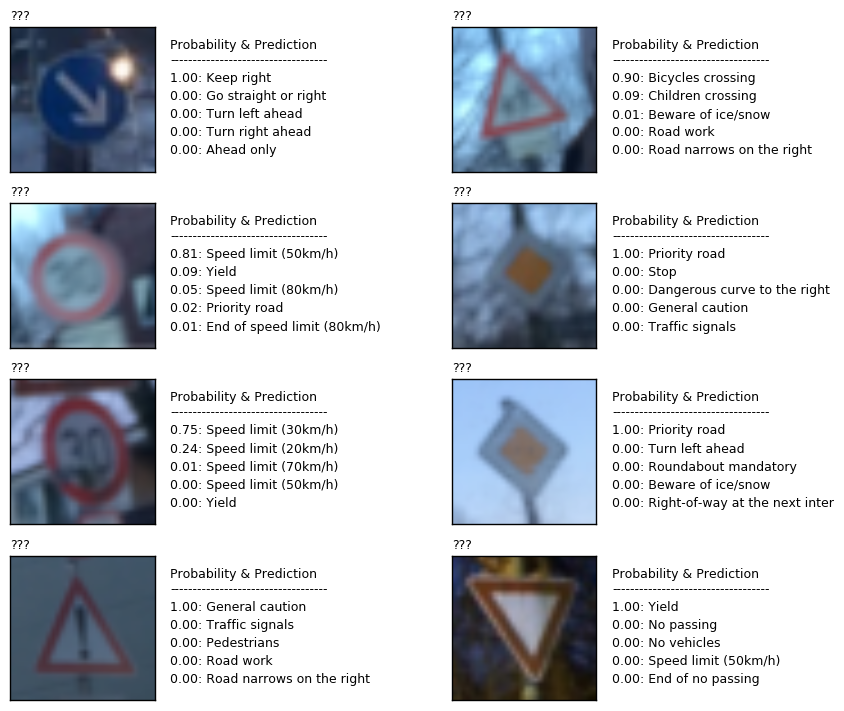

In [24]:
### Predict the new test images.

X_new_test, _, _ = preprocess(imgs, avg=X_train_avg, var=X_train_var)
print("Preprocessing done!")

print('Testing new images...')
with tf.Session() as sess:
    sess.run(init)
    load_model(sess, SAVE_PATH)
    
    new_test_pred, new_test_acc, new_test_prob_values, new_test_prob_indices = \
       evaluate(X_new_test, np.zeros(len(X_new_test)), BATCH_SIZE)
    
print('Testing done!')

plot_prediction(restore(X_new_test, X_train_avg, X_train_var), None, 
                new_test_pred, new_test_prob_values, new_test_prob_indices, n_row=4, n_col=2, false_only=True)

The model fails at two images. One is a "30km/h speed limit" sign, and the other is a "children crossing" sign. Both signs are vague but still can be distinguished by human eyes. Therefore, it might be useful to include image blurring in the data augmentation.

----
## Summary

In this project, a deep convolutional neural network has been built to classify the traffic signs in Germany. For the best model, the accuracies on the training, validaton and testing data set are **0.9938**, **0.9960** and **0.9758** respectively. Specifically, the model was found to have difficulties at vague numbers.